In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from PIL import Image
import os


In [2]:
class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()
        base_model = resnet50(pretrained=True)  # Load a pre-trained ResNet50
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.fc1 = nn.Linear(2048, 1024)  # ResNet50 features before the last layer are 2048
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward_once(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [3]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SiameseResNet().to(device)
criterion = ContrastiveLoss().to(device)  # Assuming the ContrastiveLoss class is defined as before
optimizer = optim.Adam(net.parameters(), lr=0.001)


/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import functional
import numpy as np
import random

class ImagePairDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize the input image to 256x256
            transforms.ToTensor()           # Convert the image to a tensor
        ])
        self.image_pairs = self.load_image_pairs()

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image1_path, image2_path, label = self.image_pairs[idx]
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
        image1 = self.transform(image1)
        image2 = self.transform(image2)

        return image1, image2, label

    def load_image_pairs(self):
        image_pairs = []
        similar_dir = os.path.join(self.root_dir, "similar_all_images")
        dissimilar_dir = os.path.join(self.root_dir, "dissimilar_all_images")

        # Load similar image pairs with label 1
        similar_images = os.listdir(similar_dir)
        for i in range(0, len(similar_images), 2):
            image1_path = os.path.join(similar_dir, similar_images[i])
            image2_path = os.path.join(similar_dir, similar_images[i + 1])
            image_pairs.append((image1_path, image2_path, 1))  # Label 1 for similar

        # Load dissimilar image pairs with label 0
        dissimilar_images = os.listdir(dissimilar_dir)
        for i in range(0, len(dissimilar_images), 2):
            image1_path = os.path.join(dissimilar_dir, dissimilar_images[i])
            image2_path = os.path.join(dissimilar_dir, dissimilar_images[i + 1])
            image_pairs.append((image1_path, image2_path, 0))  # Label 0 for dissimilar

        return image_pairs

# Set the dataset root directory
dataset = ImagePairDataset("/workspaces/finetune/organized_categories")

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Epoch 0, Batch 0, Loss: 0.4380890130996704
Epoch 1, Batch 0, Loss: 0.5465443730354309
Epoch 2, Batch 0, Loss: 0.41630303859710693
Epoch 3, Batch 0, Loss: 0.32005226612091064
Epoch 4, Batch 0, Loss: 0.2487393021583557
Epoch 5, Batch 0, Loss: 0.31415945291519165
Epoch 6, Batch 0, Loss: 0.28437161445617676
Epoch 7, Batch 0, Loss: 0.10743200778961182
Epoch 8, Batch 0, Loss: 0.048064351081848145
Epoch 9, Batch 0, Loss: 0.062274377793073654
Model saved to siamese_resnet_model.pth


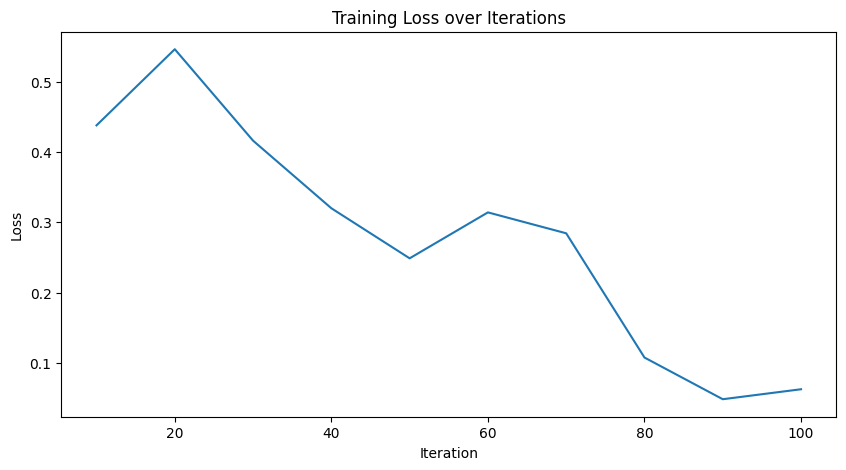

In [6]:
num_epochs = 10
counter = []
loss_history = []
iteration_number = 0

net.train()
for epoch in range(num_epochs):
    for i, (img0, img1, label) in enumerate(train_loader):
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss_contrastive.item()}")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

# Save the model
model_path = 'siamese_resnet_model.pth'
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Function to show loss over iterations
def show_plot(iteration, loss):
    plt.figure(figsize=(10, 5))
    plt.plot(iteration, loss)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.show()

show_plot(counter, loss_history)


In [7]:
# Assuming the model is defined as SiameseNetwork
model = SiameseResNet()

# Load the trained weights (substitute your model's saved weights path)
model.load_state_dict(torch.load('/workspaces/finetune/model/siamese_resnet_model.pth'))
model.eval()
model.to(device)

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [8]:
from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Add normalization if it was used during training
])

def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

In [9]:
def infer_similarity(reference_image_path, comparison_images_folder):
    reference_image = load_and_transform_image(reference_image_path).unsqueeze(0).to(device)
    
    # Load and process each comparison image
    similarities = []
    for image_name in os.listdir(comparison_images_folder):
        image_path = os.path.join(comparison_images_folder, image_name)
        comparison_image = load_and_transform_image(image_path).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Get the feature vectors
            output_ref = model.forward_once(reference_image)
            output_comp = model.forward_once(comparison_image)
            
            # Calculate the Euclidean distance or another similarity metric
            similarity = F.pairwise_distance(output_ref, output_comp)
            similarities.append((image_name, similarity.item()))
    
    # Sort by similarity
    similarities.sort(key=lambda x: x[1])
    return similarities


In [10]:
def show_images(image_paths):
    if not image_paths:
        print("No images to display.")
        return

    # If there are images, display them
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 10))
    if len(image_paths) == 1:  # When there is only one image, axes is not a list
        axes = [axes]
    for ax, img_path in zip(axes, image_paths):
        image = Image.open("data_test/"+img_path)
        ax.imshow(image)
        ax.axis('off')
    plt.show()


In [15]:
reference_path = '/workspaces/finetune/data_test/3001753967(2).jpg'
comparison_folder = '/workspaces/finetune/data_test'

# Get the top 5 most similar images
similarities = infer_similarity(reference_path, comparison_folder)
top_5_similar = similarities[:5]

img_list = []
for img, score in top_5_similar:
    img_list.append(img)
    print(f"Image: {img}, Similarity Score: {score}")

Image: 3001753967(2).jpg, Similarity Score: 9.999999974752427e-07
Image: 2999556200(2).JPG, Similarity Score: 0.0023494495544582605
Image: 3001578113(2).jpg, Similarity Score: 0.004645271692425013
Image: 3001529018(11).jpg, Similarity Score: 0.005319608841091394
Image: 3001529018(10).jpg, Similarity Score: 0.006290750112384558


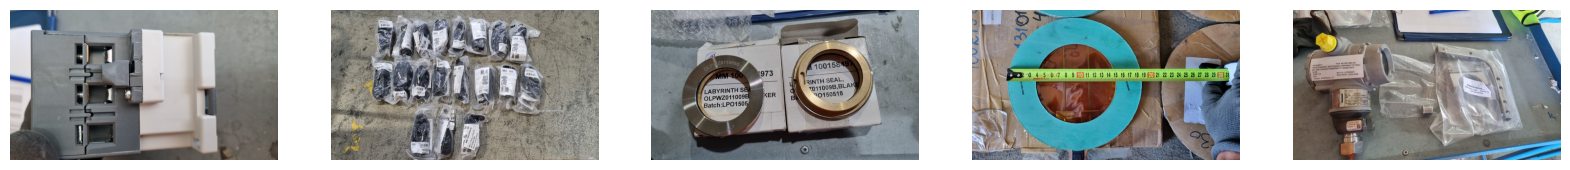

In [14]:
show_images(img_list)